This is a notebook dedicated to investigating the properties of CHE stars on the MS from MESA output.

### Prelude

In [21]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import astropy.units as u
import astropy.constants as ct
from astropy.cosmology import WMAP9

import mesa_reader as mr

In [22]:
plt.style.use('./plotstyle.mplstyle')

### References

Gottlieb, O., Renzo, M., Metzger, B. D., Goldberg, J. A. & Cantiello, M., *She's got her mother's hair: end-to-end collapsar simulations unveil the origin of black holes' magnetic field*, 2024, [arXiv:2407.16745](https://ui.adsabs.harvard.edu/abs/2024arXiv240716745G/abstract)  
Nugis, T. & Lamers, H. J. G. L. M., *Mass-loss rates of Wolf-Rayet stars as a function of stellar parameters*, 2000, [A&A 360, 227](https://ui.adsabs.harvard.edu/abs/2000A%26A...360..227N/abstract)  
Vink, J. S., de Koter, A. & Lamers, H. J. G. L. M., *New theoretical mass-loss rates of O and B Stars*, 2000, [A&A, 362, 295](https://ui.adsabs.harvard.edu/abs/2000A%26A...362..295V/abstract)

### Definitions

In [23]:
Z_SUN = 0.02
MASS_U = u.M_sun
PERIOD_U = u.day
AGE_U = u.Myr
SMA_U = u.R_sun
RADIUS_U = u.R_sun
TEMP_U = u.kK
LUMINOSITY_U = u.Lsun

Z_SUN = 0.02
t_H = WMAP9.age(0).to(AGE_U)

In [24]:
def fix_unit(var, unit):
    """If a variable is passed without a unit, set it to a specified one."""
    if type(var) != u.quantity.Quantity:
        var *= unit
    else:
        pass
    return var

In [25]:
def log_g(m, r, metallicity=Z_SUN):
    m = fix_unit(m, MASS_U)
    r = fix_unit(r, RADIUS_U)
    g = (ct.G * m / r**2).to(u.cm / u.s**2)
    log_g = np.log10(g.value)
    return log_g


In [26]:
def t_eff(l, r, metallicity=Z_SUN):
    l = fix_unit(l, LUMINOSITY_U)
    r = fix_unit(r, RADIUS_U)
    t_eff = l / (4*np.pi*r**2 * ct.sigma_sb)
    t_eff = t_eff**(1/4)
    return t_eff.to(TEMP_U)

In [27]:
def tau_he_ms(m):
    m = fix_unit(m, MASS_U).to(MASS_U).value
    coefficients = np.array([0.4129, 18.81, 1.853, 1]) 
    indices = np.array([0, 4, 6, 6.5])
    terms = coefficients * m**indices
    return np.sum(terms[:3]) / np.sum(terms[3:]) * u.Myr

In [28]:
class ToutMassRadiusRelation:
    """Mass-radius relation at ZAMS from Tout et al. (1996)."""

    def __init__(self, metallicity=Z_SUN):
        self.metallicity = metallicity
        self.fit_params = None
        self.coefficients = None
        self._load_fit_params()
        self._set_coefficients()

    def _load_fit_params(self):
        self.fit_params = np.genfromtxt('tout_zams_mrr', skip_header=True, usecols=(1, 2, 3, 4, 5))
    
    def _set_coefficients(self):
        met_factor = np.array([np.log10(self.metallicity/Z_SUN)**i for i in range(5)])
        met_factor = np.tile(met_factor, (10, 1))
        met_factor[-2] = np.ones(5)/5
        self.coefficients = self.fit_params * met_factor
        self.coefficients = np.sum(self.coefficients, axis=1)

    def radius(self, m):
        m = fix_unit(m, MASS_U).to(u.Msun).value
        indices = np.array([2.5, 6.5, 11, 19, 19.5, 0, 2, 8.5, 18.5, 19.5])
        terms = self.coefficients * m**indices
        radius = np.sum(terms[:5]) / np.sum(terms[5:])
        return radius * u.Rsun
        

In [29]:
class ToutMassLuminosityRelation:
    """Mass-radius relation at ZAMS from Tout et al. (1996)."""

    def __init__(self, metallicity=Z_SUN):
        self.metallicity = metallicity
        self.fit_params = None
        self.coefficients = None
        self._load_fit_params()
        self._set_coefficients()

    def _load_fit_params(self):
        self.fit_params = np.genfromtxt('tout_zams_mlr', skip_header=True, usecols=(1, 2, 3, 4, 5))
    
    def _set_coefficients(self):
        met_factor = np.array([np.log10(self.metallicity/Z_SUN)**i for i in range(5)])
        met_factor = np.tile(met_factor, (8, 1))
        met_factor[-2] = np.ones(5)/5
        self.coefficients = self.fit_params * met_factor
        self.coefficients = np.sum(self.coefficients, axis=1)

    def luminosity(self, m):
        m = fix_unit(m, MASS_U).to(u.Msun).value
        indices = np.array([5.5, 11, 0, 3, 5, 7, 8, 9.5])
        terms = self.coefficients * m**indices
        luminosity = np.sum(terms[:2]) / np.sum(terms[2:])
        return luminosity * u.Lsun
        

In [30]:
class HurleyMassRadiusRelation:

    def __init__(self, metallicity=Z_SUN):
        self.metallicity = metallicity

    def _beta(self, m):
        m = fix_unit(m, MASS_U).value
        return max(0, 0.4 - 0.22 * np.log10(m))

    def zams_radius(self, m):
        m = fix_unit(m, MASS_U).to(MASS_U).value
        coefficients = np.array([0.2391, 1, 0.162, 0.0065])
        indices = np.array([4.6, 4, 3, 0])
        terms = coefficients * m**indices
        zams_radius = np.sum(terms[:1]) / np.sum(terms[1:])
        return zams_radius * u.Rsun

    def radius(self, m, t=0):
        m = fix_unit(m, MASS_U)
        t = fix_unit(t, AGE_U)
        tau = (t/tau_he_ms(m)).value
        beta = self._beta(m)
        r_zams = self.zams_radius(m)
        return (1 + beta*tau - beta*tau**6) * r_zams

In [31]:
class HurleyMassLuminosityRelation:

    def __init__(self, metallicity=Z_SUN):
        self.metallicity = metallicity

    def _alpha(self, m):
        m = fix_unit(m, MASS_U).value
        return max(0, 0.85 - 0.08 * m)

    def zams_luminosity(self, m):
        m = fix_unit(m, MASS_U).to(MASS_U).value
        coefficients = np.array([15262, 1, 29.54, 31.18, 0.0469])
        indices = np.array([10.25, 9, 7.5, 6, 0])
        terms = coefficients * m**indices
        zams_luminosity = np.sum(terms[:1]) / np.sum(terms[1:])
        return zams_luminosity * u.Lsun

    def luminosity(self, m, t=0):
        m = fix_unit(m, MASS_U)
        t = fix_unit(t, AGE_U)
        tau = (t/tau_he_ms(m)).value
        alpha = self._alpha(m)
        l_zams = self.zams_luminosity(m)
        return (1 + 0.45*tau + alpha*tau**2) * l_zams

### Analysis

Below we load the original output files from Gottlieb et al. (2024).

In [32]:
ROOT = Path.cwd().parent
LOGS_FOLDER = ROOT/'mesa/original_files/ore_original_input_test/LOGS'

In [33]:
h = mr.MesaData(str(LOGS_FOLDER/'history.data'))
logs = mr.MesaLogDir(str(LOGS_FOLDER))

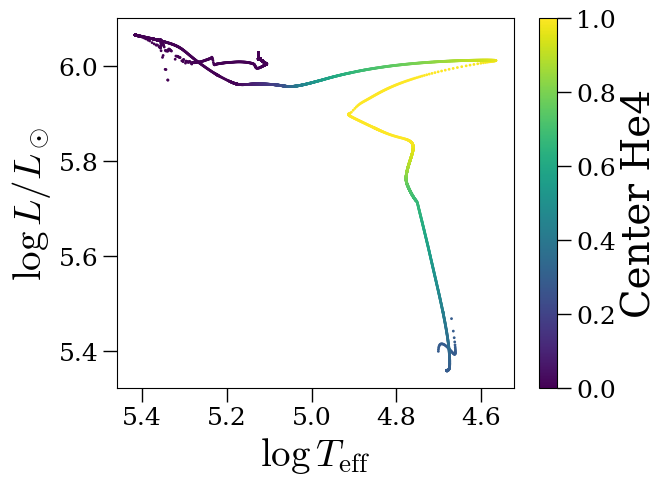

In [34]:
cmap = cm.viridis

fig, ax = plt.subplots()

ax.scatter(h.log_Teff, h.log_L, c=h.center_he4, cmap=cmap, s=1)
ax.invert_xaxis()

ax.set_xlabel('$\\log T_\\mathrm{eff}$')
ax.set_ylabel('$\\log L/L_\\odot$')

cb = plt.colorbar(mappable=ScalarMappable(Normalize(vmin=0, vmax=1)), cmap=cmap, ax=ax)
cb_label = cb.set_label('Center He4')

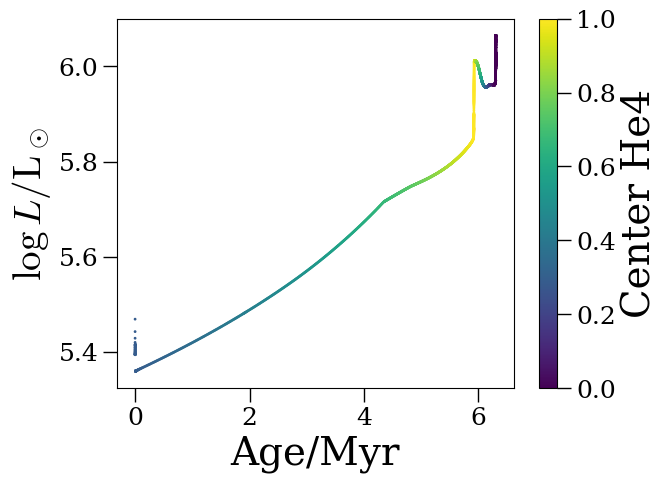

In [35]:
cmap = cm.viridis

fig, ax = plt.subplots()

ax.scatter(h.star_age/1e6, h.log_L, c=h.center_he4, cmap=cmap, s=1)

ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

cb = plt.colorbar(mappable=ScalarMappable(Normalize(vmin=0, vmax=1)), cmap=cmap, ax=ax)
cb.set_label('Center He4')

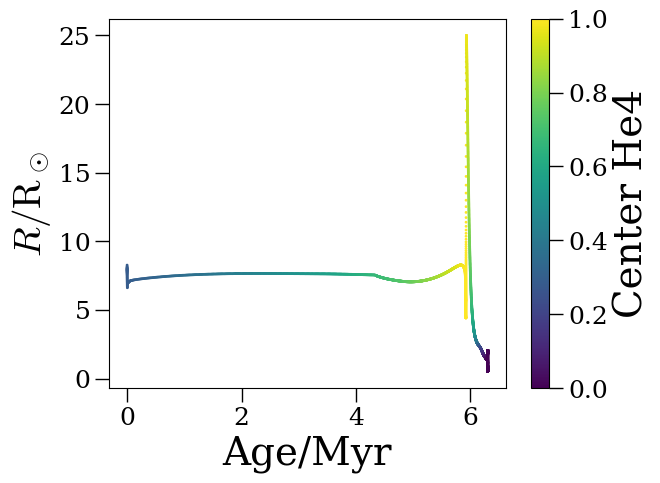

In [36]:
cmap = cm.viridis

fig, ax = plt.subplots()

ax.scatter(h.star_age/1e6, h.radius, c=h.center_he4, cmap=cmap, s=1)

ax.set_xlabel('Age/Myr')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')

cb = plt.colorbar(mappable=ScalarMappable(Normalize(vmin=0, vmax=1)), cmap=cmap, ax=ax)
cb.set_label('Center He4')

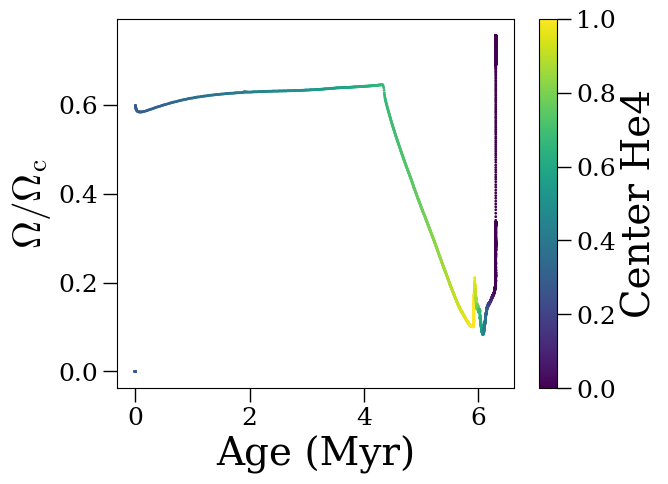

In [37]:
cmap = cm.viridis

fig, ax = plt.subplots()

ax.scatter(h.star_age/1e6, h.surf_avg_omega_div_omega_crit, c=h.center_he4, cmap=cmap, s=1)

ax.set_xlabel('Age (Myr)')
ax.set_ylabel('$\\Omega/\\Omega_\\mathrm{c}$')

cb = plt.colorbar(mappable=ScalarMappable(Normalize(vmin=0, vmax=1)), cmap=cmap, ax=ax)
cb.set_label('Center He4')

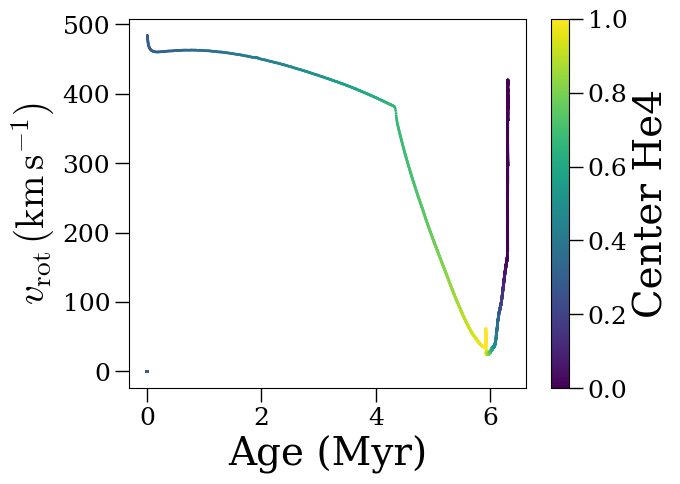

In [38]:
cmap = cm.viridis

fig, ax = plt.subplots()

ax.scatter(h.star_age/1e6, h.surf_avg_v_rot, c=h.center_he4, cmap=cmap, s=1)

ax.set_xlabel('Age (Myr)')
ax.set_ylabel('$v_\\mathrm{rot}\,(\\mathrm{km}\,\\mathrm{s}^{-1})$')

cb = plt.colorbar(mappable=ScalarMappable(Normalize(vmin=0, vmax=1)), cmap=cmap, ax=ax)
cb.set_label('Center He4')

Gottlieb et al. (2024) implement the Dutch wind scheme, which in MESA, for $T_\mathrm{eff}>10^{4}\,\mathrm{K}$, switches from the massive MS star mass loss prescription by Vink et al. (2001) ($\dot{M}\sim10^{-7}-10^{-6}\,\mathrm{M}_\odot\,\mathrm{yr}^{-1}$) to the WR star mass loss prescription by Nugis & Lamers (2000) ($\dot{M}\sim10^{-5}-10^{-4}\,\mathrm{M}_\odot\,\mathrm{yr}^{-1}$) when the surface H fraction drops below $0.4$.

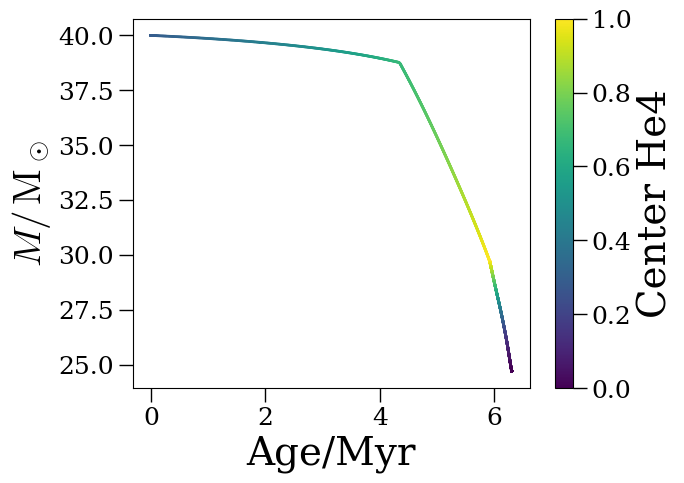

In [39]:
cmap = cm.viridis

fig, ax = plt.subplots()

ax.scatter(h.star_age/1e6, h.star_mass, c=h.center_he4, cmap=cmap, s=1)

ax.set_ylabel('$M/\\,\\mathrm{M}_\odot$')
ax.set_xlabel('Age/Myr')

cb = plt.colorbar(mappable=ScalarMappable(Normalize(vmin=0, vmax=1)), cmap=cmap, ax=ax)
cb.set_label('Center He4')

In [40]:
zams_i = np.argmax(h.surf_avg_v_rot)

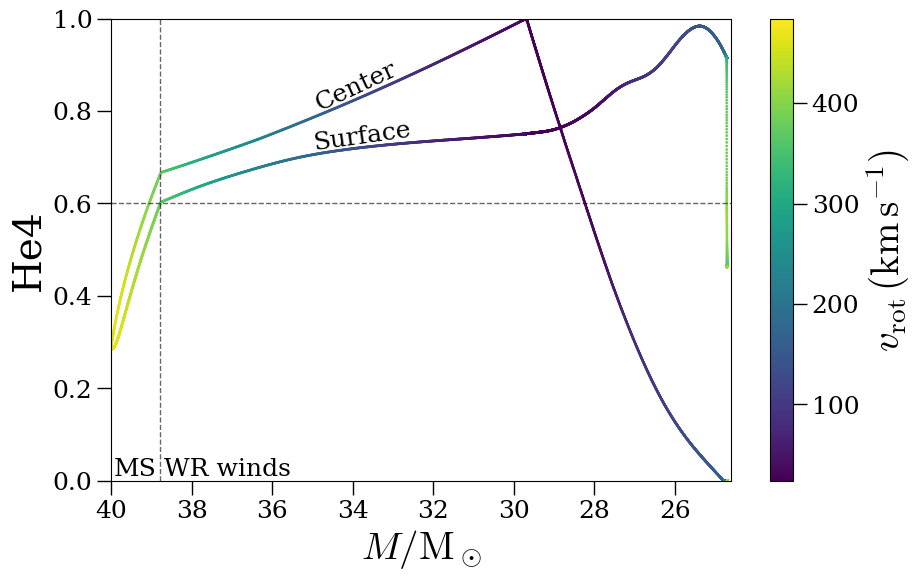

In [41]:
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(h.star_mass[zams_i:], h.surface_he4[zams_i:], c=h.surf_avg_v_rot[zams_i:], cmap=cmap, s=1)
ax.scatter(h.star_mass[zams_i:], h.center_he4[zams_i:], c=h.surf_avg_v_rot[zams_i:], cmap=cmap, marker='^', s=1)

ax.hlines(0.6, 40, 24.6, color='k', ls='--', lw=1, alpha=0.6)
ax.vlines(h.star_mass[np.argmin(np.abs(h.surface_he4-0.6))], 0, 1, color='k', ls='--', lw=1, alpha=0.6)
ax.text(h.star_mass[np.argmin(np.abs(h.surface_he4-0.6))]+0.1, 0, 'MS', ha='right', va='bottom', fontsize=18)
ax.text(h.star_mass[np.argmin(np.abs(h.surface_he4-0.6))]-0.1, 0, 'WR winds', ha='left', va='bottom', fontsize=18)

ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('He4')
ax.set_xlim(40, 24.6)
ax.set_ylim(0, 1)

ax.text(35, 0.79, 'Center', rotation=25, ha='left', va='bottom', transform=ax.transData, fontsize=18)
ax.text(35, 0.785, 'Surface', rotation=8, ha='left', va='top', transform=ax.transData, fontsize=18)

cb = plt.colorbar(mappable=ScalarMappable(Normalize(vmin=min(h.surf_avg_v_rot[zams_i:]), vmax=max(h.surf_avg_v_rot[zams_i:]))), cmap=cmap, ax=ax)
cb.set_label('$v_\\mathrm{rot}\\,(\\mathrm{km}\\,\\mathrm{s}^{-1})$')

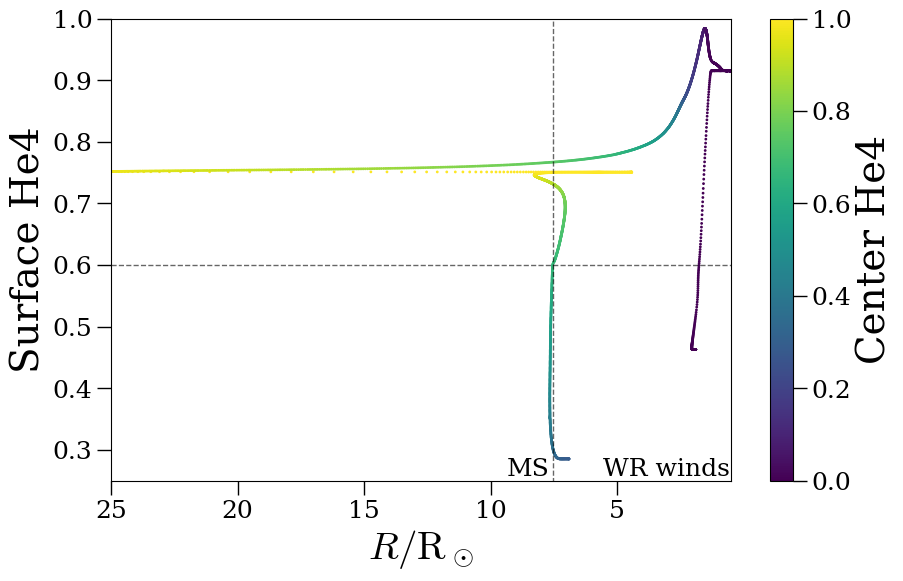

In [42]:
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(h.radius[zams_i:], h.surface_he4[zams_i:], c=h.center_he4[zams_i:], cmap=cm.viridis, s=1)
#ax.scatter(h.radius[zams_i:], h.center_he4[zams_i:], c=h.surf_avg_v_rot[zams_i:], cmap=cm.viridis, marker='^', s=1)

ax.hlines(0.6, 25, 0, color='k', ls='--', lw=1, alpha=0.6)
ax.vlines(h.radius[np.argmin(np.abs(h.surface_he4-0.6))], 25, 0, color='k', ls='--', lw=1, alpha=0.6)
ax.text(h.radius[np.argmin(np.abs(h.surface_he4-0.6))]+0.1, 0.25, 'MS', ha='right', va='bottom', fontsize=18)
ax.text(h.radius[np.argmin(np.abs(h.surface_he4-0.6))]-2, 0.25, 'WR winds', ha='left', va='bottom', fontsize=18)

ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
ax.set_ylabel('Surface He4')
ax.set_xlim(25, 0.5)
ax.set_ylim(0.25, 1)

#ax.text(35, 0.79, 'Center', rotation=25, ha='left', va='bottom', transform=ax.transData, fontsize=18)
#ax.text(35, 0.785, 'Surface', rotation=8, ha='left', va='top', transform=ax.transData, fontsize=18)

cb = plt.colorbar(mappable=ScalarMappable(Normalize(vmin=0, vmax=1)), cmap=cmap, ax=ax)
cb.set_label('Center He4')

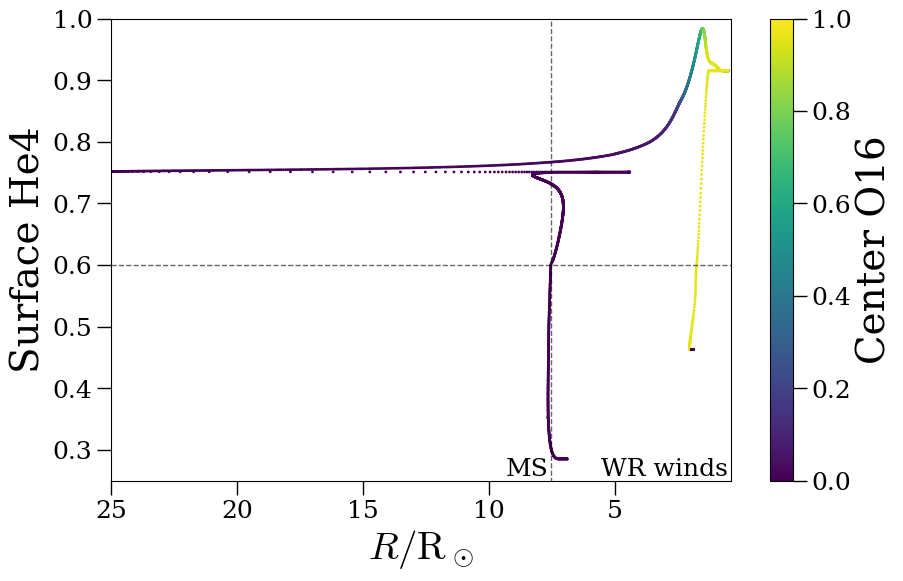

In [43]:
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(h.radius[zams_i:], h.surface_he4[zams_i:], c=h.center_o16[zams_i:], cmap=cm.viridis, s=1)
#ax.scatter(h.radius[zams_i:], h.center_he4[zams_i:], c=h.surf_avg_v_rot[zams_i:], cmap=cm.viridis, marker='^', s=1)

ax.hlines(0.6, 25, 0, color='k', ls='--', lw=1, alpha=0.6)
ax.vlines(h.radius[np.argmin(np.abs(h.surface_he4-0.6))], 25, 0, color='k', ls='--', lw=1, alpha=0.6)
ax.text(h.radius[np.argmin(np.abs(h.surface_he4-0.6))]+0.1, 0.25, 'MS', ha='right', va='bottom', fontsize=18)
ax.text(h.radius[np.argmin(np.abs(h.surface_he4-0.6))]-2, 0.25, 'WR winds', ha='left', va='bottom', fontsize=18)

ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
ax.set_ylabel('Surface He4')
ax.set_xlim(25, 0.4)
ax.set_ylim(0.25, 1)

#ax.text(35, 0.79, 'Center', rotation=25, ha='left', va='bottom', transform=ax.transData, fontsize=18)
#ax.text(35, 0.785, 'Surface', rotation=8, ha='left', va='top', transform=ax.transData, fontsize=18)

cb = plt.colorbar(mappable=ScalarMappable(Normalize(vmin=0, vmax=1)), cmap=cmap, ax=ax)
cb.set_label('Center O16')

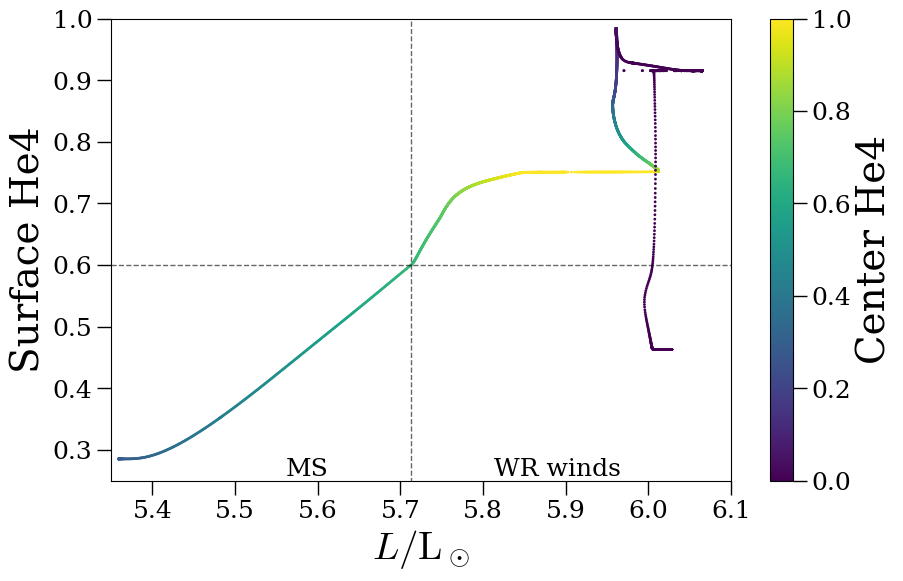

In [44]:
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(h.log_L[zams_i:], h.surface_he4[zams_i:], c=h.center_he4[zams_i:], cmap=cm.viridis, s=1)
#ax.scatter(h.radius[zams_i:], h.center_he4[zams_i:], c=h.surf_avg_v_rot[zams_i:], cmap=cm.viridis, marker='^', s=1)

ax.hlines(0.6, 5.35, 6.1, color='k', ls='--', lw=1, alpha=0.6)
ax.vlines(h.log_L[np.argmin(np.abs(h.surface_he4-0.6))], 25, 0, color='k', ls='--', lw=1, alpha=0.6)
ax.text(h.log_L[np.argmin(np.abs(h.surface_he4-0.6))]-0.1, 0.25, 'MS', ha='right', va='bottom', fontsize=18)
ax.text(h.log_L[np.argmin(np.abs(h.surface_he4-0.6))]+0.1, 0.25, 'WR winds', ha='left', va='bottom', fontsize=18)

ax.set_xlabel('$L/\\mathrm{L}_\\odot$')
ax.set_ylabel('Surface He4')
ax.set_xlim(5.35, 6.1)
ax.set_ylim(0.25, 1)

#ax.text(35, 0.79, 'Center', rotation=25, ha='left', va='bottom', transform=ax.transData, fontsize=18)
#ax.text(35, 0.785, 'Surface', rotation=8, ha='left', va='top', transform=ax.transData, fontsize=18)

cb = plt.colorbar(mappable=ScalarMappable(Normalize(vmin=0, vmax=1)), cmap=cmap, ax=ax)
cb.set_label('Center He4')

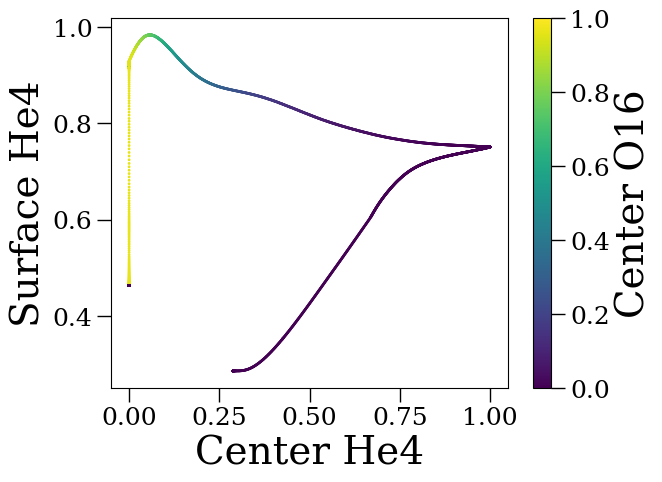

In [45]:

cmap = cm.viridis

fig, ax = plt.subplots()

ax.scatter(h.center_he4, h.surface_he4, c=h.center_o16, cmap=cmap, s=1)

ax.set_xlabel('Center He4')
ax.set_ylabel('Surface He4')

cb = plt.colorbar(mappable=ScalarMappable(Normalize(vmin=0, vmax=1)), cmap=cmap, ax=ax)
cb.set_label('Center O16')

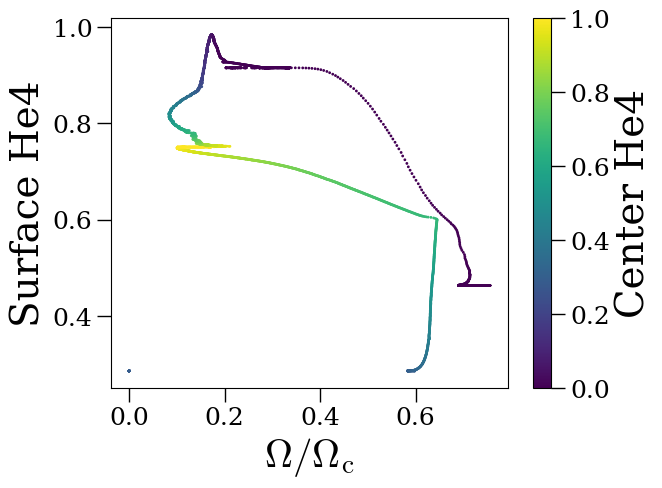

In [46]:
cmap = cm.viridis

fig, ax = plt.subplots()

ax.scatter(h.surf_avg_omega_div_omega_crit, h.surface_he4, c=h.center_he4, cmap=cmap, s=1)

ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('Surface He4')

cb = plt.colorbar(mappable=ScalarMappable(Normalize(vmin=0, vmax=1)), cmap=cmap, ax=ax)
cb.set_label('Center He4')

Text(0, 0.5, 'Center')

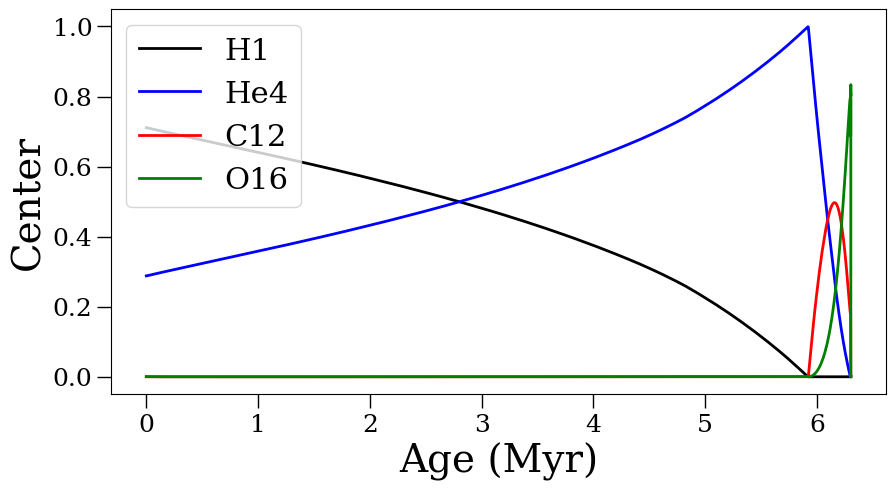

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(h.star_age/1e6, h.center_h1, 'k-', label='H1')
ax.plot(h.star_age/1e6, h.center_he4, 'b-', label='He4')
ax.plot(h.star_age/1e6, h.center_c12, 'r-', label='C12')
ax.plot(h.star_age/1e6, h.center_o16, 'g-', label='O16')

ax.legend()


ax.set_xlabel('Age (Myr)')
ax.set_ylabel('Center')

Text(0, 0.5, '$\\log j/(\\mathrm{m}^2\\,\\mathrm{s}^{-1})$')

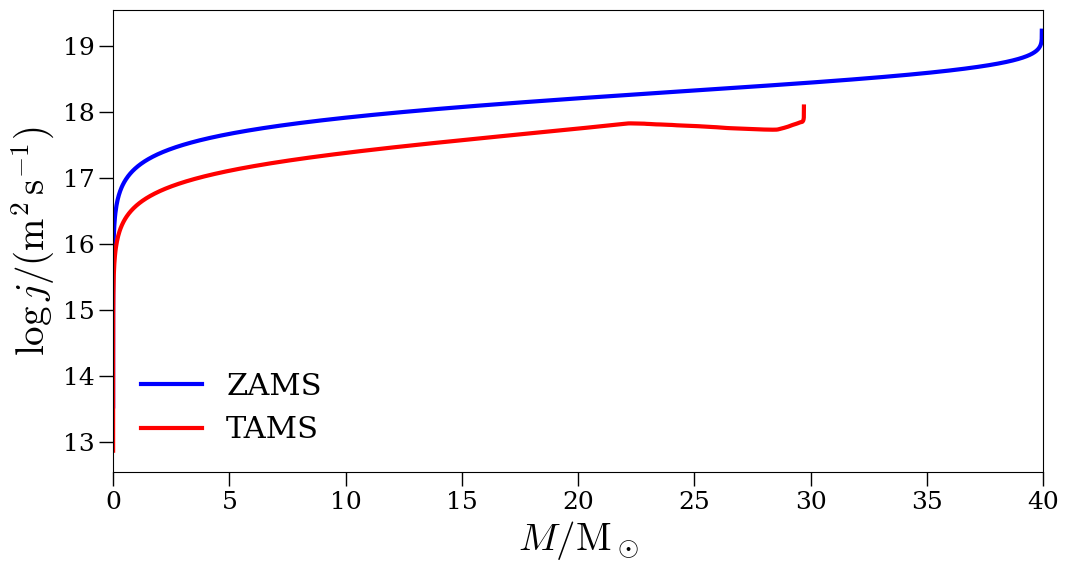

In [48]:
fig, ax = plt.subplots(figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

zams_profile = logs.profile_data(profile_number=2)
tams_profile = logs.profile_data(model_number=logs.select_models(lambda center_h1: center_h1 < 1.e-7, 'center_h1')[0])
#heex_profile = logs.profile_data(model_number=logs.select_models(lambda center_he4: center_he4 < 1.e-7, 'center_he4')[0])
#caex_profile = logs.profile_data(model_number=logs.select_models(lambda center_c12: center_c12 < 1.e-7, 'center_c12')[0])
#oxex_profile = logs.profile_data(model_number=logs.select_models(lambda center_o16: center_o16 < 1.e-6, 'center_o16')[0])

ax.plot(zams_profile.mass, zams_profile.log_j_rot, c='b', lw=3, label='ZAMS')
ax.plot(tams_profile.mass, tams_profile.log_j_rot, c='r', lw=3, label='TAMS')
#ax.plot(heex_profile.mass, heex_profile.log_j_rot, c='g', lw=3, label='He Exh.')
#ax.plot(caex_profile.mass, caex_profile.log_j_rot, c='m', lw=3, label='C Exh.')
#ax.plot(oxex_profile.mass, oxex_profile.log_j_rot, c='c', lw=3, label='O Exh.')

ax.legend(frameon=False)

ax.set_xlim(0, 40)

ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\log j/(\\mathrm{m}^2\\,\\mathrm{s}^{-1})$')

In [49]:
np.logspace(np.log10(0.5), np.log10(4), 10)

array([0.5       , 0.62996052, 0.79370053, 1.        , 1.25992105,
       1.58740105, 2.        , 2.5198421 , 3.1748021 , 4.        ])

In [50]:
np.logspace(np.log10(3), 2.5, 10)

array([  3.        ,   5.0336795 ,   8.44597642,  14.17144612,
        23.77817258,  39.89723326,  66.94329501, 112.32369716,
       188.46716378, 316.22776602])

Text(0, 0.5, '$\\log j/(\\mathrm{m}^2\\,\\mathrm{s}^{-1})$')

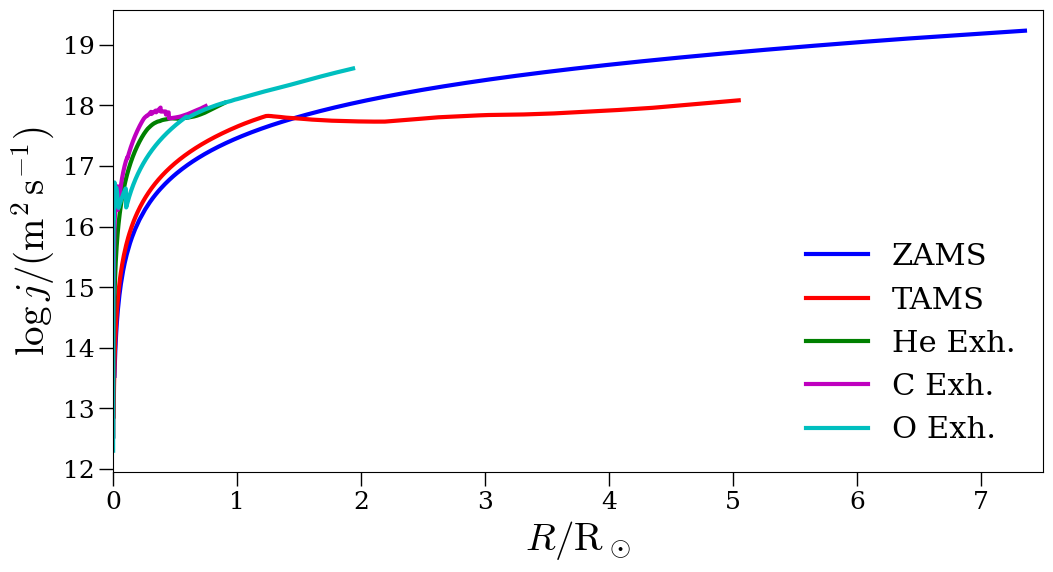

In [51]:
fig, ax = plt.subplots(figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

zams_profile = logs.profile_data(profile_number=2)
tams_profile = logs.profile_data(model_number=logs.select_models(lambda center_h1: center_h1 < 1.e-7, 'center_h1')[0])
heex_profile = logs.profile_data(model_number=logs.select_models(lambda center_he4: center_he4 < 1.e-7, 'center_he4')[0])
caex_profile = logs.profile_data(model_number=logs.select_models(lambda center_c12: center_c12 < 1.e-7, 'center_c12')[0])
oxex_profile = logs.profile_data(model_number=logs.select_models(lambda center_o16: center_o16 < 1.e-6, 'center_o16')[0])

ax.plot(zams_profile.radius, zams_profile.log_j_rot, c='b', lw=3, label='ZAMS')
ax.plot(tams_profile.radius, tams_profile.log_j_rot, c='r', lw=3, label='TAMS')
ax.plot(heex_profile.radius, heex_profile.log_j_rot, c='g', lw=3, label='He Exh.')
ax.plot(caex_profile.radius, caex_profile.log_j_rot, c='m', lw=3, label='C Exh.')
ax.plot(oxex_profile.radius, oxex_profile.log_j_rot, c='c', lw=3, label='O Exh.')

ax.legend(frameon=False)

ax.set_xlim(0, 7.5)

ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
ax.set_ylabel('$\\log j/(\\mathrm{m}^2\\,\\mathrm{s}^{-1})$')

Text(0, 0.5, '$\\log j/(\\mathrm{m}^2\\,\\mathrm{s}^{-1})$')

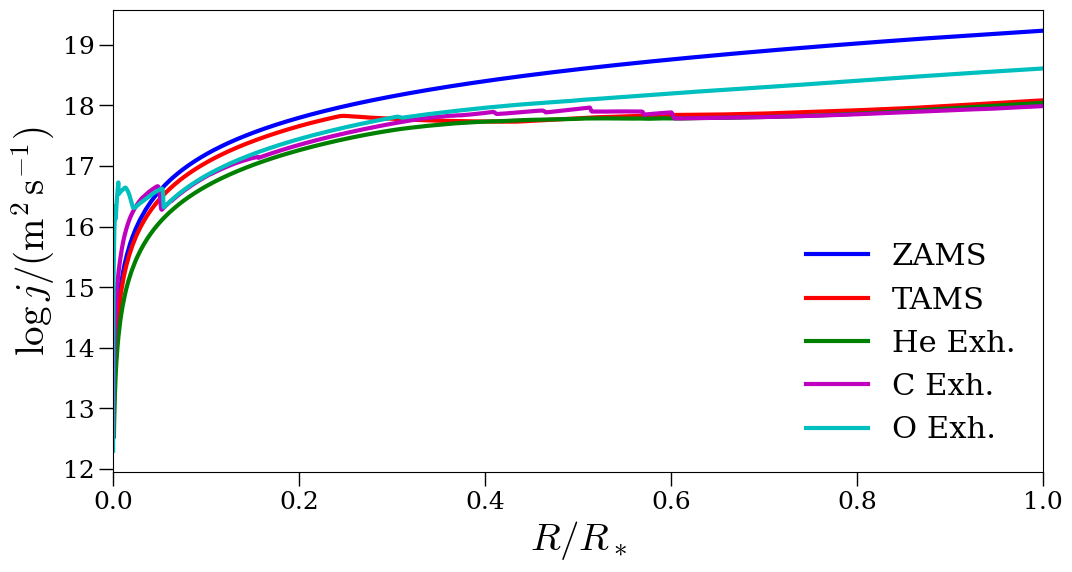

In [52]:
fig, ax = plt.subplots(figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

zams_profile = logs.profile_data(profile_number=2)
tams_profile = logs.profile_data(model_number=logs.select_models(lambda center_h1: center_h1 < 1.e-7, 'center_h1')[0])
heex_profile = logs.profile_data(model_number=logs.select_models(lambda center_he4: center_he4 < 1.e-7, 'center_he4')[0])
caex_profile = logs.profile_data(model_number=logs.select_models(lambda center_c12: center_c12 < 1.e-7, 'center_c12')[0])
oxex_profile = logs.profile_data(model_number=logs.select_models(lambda center_o16: center_o16 < 1.e-6, 'center_o16')[0])

ax.plot(zams_profile.radius/max(zams_profile.radius), zams_profile.log_j_rot, c='b', lw=3, label='ZAMS')
ax.plot(tams_profile.radius/max(tams_profile.radius), tams_profile.log_j_rot, c='r', lw=3, label='TAMS')
ax.plot(heex_profile.radius/max(heex_profile.radius), heex_profile.log_j_rot, c='g', lw=3, label='He Exh.')
ax.plot(caex_profile.radius/max(caex_profile.radius), caex_profile.log_j_rot, c='m', lw=3, label='C Exh.')
ax.plot(oxex_profile.radius/max(oxex_profile.radius), oxex_profile.log_j_rot, c='c', lw=3, label='O Exh.')

ax.legend(frameon=False)

ax.set_xlim(0, 1)

ax.set_xlabel('$R/R_\\ast$')
ax.set_ylabel('$\\log j/(\\mathrm{m}^2\\,\\mathrm{s}^{-1})$')

In [53]:
from matplotlib.lines import Line2D

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


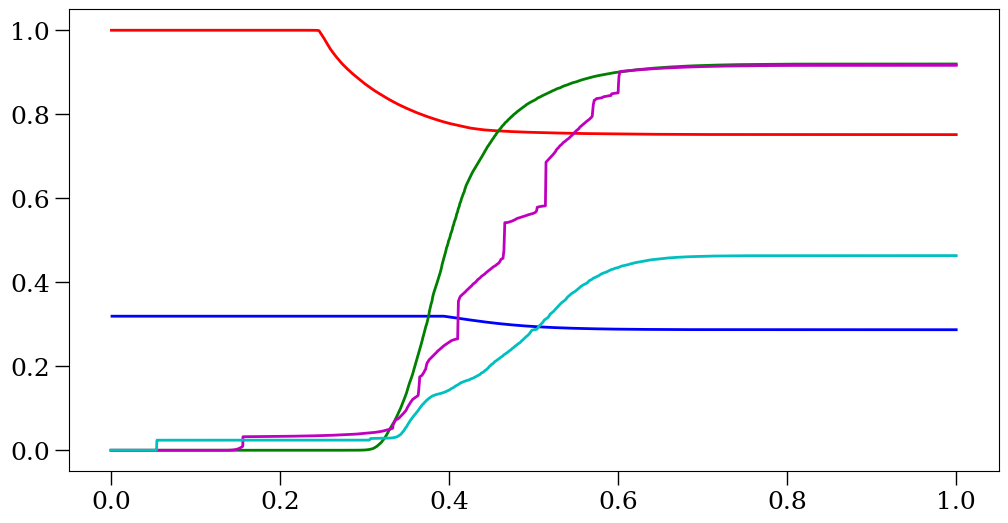

In [54]:
fig, ax = plt.subplots(figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

zams_profile = logs.profile_data(profile_number=2)
tams_profile = logs.profile_data(model_number=logs.select_models(lambda center_h1: center_h1 < 1.e-7, 'center_h1')[0])
heex_profile = logs.profile_data(model_number=logs.select_models(lambda center_he4: center_he4 < 1.e-7, 'center_he4')[0])
caex_profile = logs.profile_data(model_number=logs.select_models(lambda center_c12: center_c12 < 1.e-7, 'center_c12')[0])
oxex_profile = logs.profile_data(model_number=logs.select_models(lambda center_o16: center_o16 < 1.e-6, 'center_o16')[0])

#ax.plot(zams_profile.radius/max(zams_profile.radius), zams_profile.x_mass_fraction_H, c='b', ls='-', lw=2)
#ax.plot(tams_profile.radius/max(tams_profile.radius), tams_profile.x_mass_fraction_H, c='r', ls='-', lw=2)
#ax.plot(heex_profile.radius/max(heex_profile.radius), heex_profile.x_mass_fraction_H, c='g', ls='-', lw=2)
#ax.plot(caex_profile.radius/max(caex_profile.radius), caex_profile.x_mass_fraction_H, c='m', ls='-', lw=2)
#ax.plot(oxex_profile.radius/max(oxex_profile.radius), oxex_profile.x_mass_fraction_H, c='c', ls='-', lw=2)

ax.plot(zams_profile.radius/max(zams_profile.radius), zams_profile.y_mass_fraction_He, c='b', ls='-', lw=2)
ax.plot(tams_profile.radius/max(tams_profile.radius), tams_profile.y_mass_fraction_He, c='r', ls='-', lw=2)
ax.plot(heex_profile.radius/max(heex_profile.radius), heex_profile.y_mass_fraction_He, c='g', ls='-', lw=2)
ax.plot(caex_profile.radius/max(caex_profile.radius), caex_profile.y_mass_fraction_He, c='m', ls='-', lw=2)
ax.plot(oxex_profile.radius/max(oxex_profile.radius), oxex_profile.y_mass_fraction_He, c='c', ls='-', lw=2)

#ax.plot(zams_profile.radius/max(zams_profile.radius), zams_profile.z_mass_fraction_metals, c='b', ls=':', lw=2)
#ax.plot(tams_profile.radius/max(tams_profile.radius), tams_profile.z_mass_fraction_metals, c='r', ls=':', lw=2)
#ax.plot(heex_profile.radius/max(heex_profile.radius), heex_profile.z_mass_fraction_metals, c='g', ls=':', lw=2)
#ax.plot(caex_profile.radius/max(caex_profile.radius), caex_profile.z_mass_fraction_metals, c='m', ls=':', lw=2)
#ax.plot(oxex_profile.radius/max(oxex_profile.radius), oxex_profile.z_mass_fraction_metals, c='c', ls=':', lw=2)

handles = []
handles.append(Line2D((0,0), (-1,-1), linestyle='-', color='b', label='ZAMS'))
               
ax.legend(frameon=False)

In [55]:
def tau_es(tau_kh, m, r, v_rot):
    m = fix_unit(m, MASS_U)
    r = fix_unit(r, RADIUS_U)
    tau_kh = fix_unit(tau_kh, u.yr)
    v_rot = fix_unit(v_rot, u.km/u.s)
    omega = 2*np.pi * v_rot / r
    tau_es = tau_kh * ct.G * m / (omega**2 * r**3)   
    return tau_es.to(u.yr).value
    

es_timescale = np.array([tau_es(t_kh, m, r, v_rot) for t_kh, m, r, v_rot in zip(h.kh_timescale, h.star_mass, h.radius, h.surf_avg_v_rot)])

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0, 0.5, 'Timescale (kyr)')

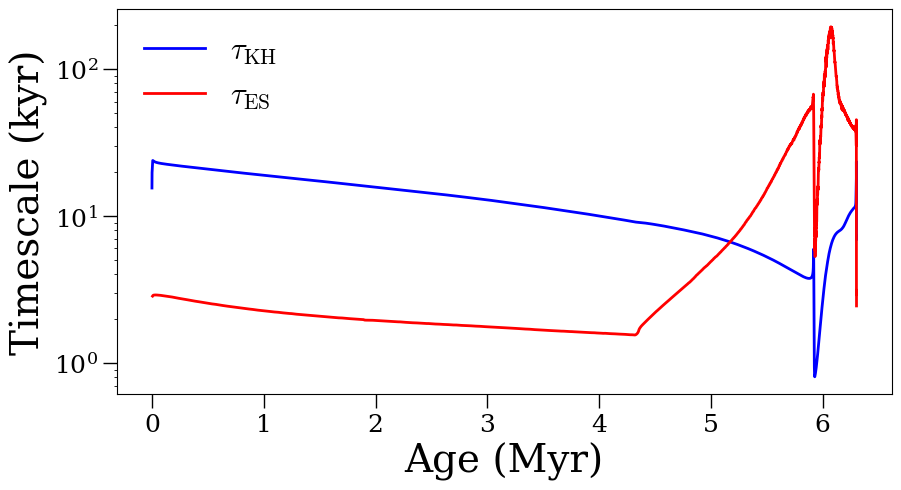

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(h.star_age/1e6, h.kh_timescale/1e3, 'b-', label='$\\tau_\\mathrm{KH}$')
ax.plot(h.star_age/1e6, es_timescale/1e3, 'r-', label='$\\tau_\\mathrm{ES}$')

ax.legend(frameon=False)
ax.set_yscale('log')

ax.set_xlabel('Age (Myr)')
ax.set_ylabel('Timescale (kyr)')